In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps
import gmaps.datasets
import ipyleaflet
from IPython.display import display

In [112]:
#importing environment variables
from dotenv import dotenv_values
env_variables = dotenv_values('Ignore.env')

In [113]:
df = pd.read_csv('/Users/emilydanielbowser/Documents/Iowa Food Coop/Data/Intermediate Data/Wrangled_data')

/var/folders/7b/nyzqb3pd1zn309ndm96_lqcm0000gn/T/ipykernel_74391/3929973976.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/emilydanielbowser/Documents/Iowa Food Coop/Data/Intermediate Data/Wrangled_data')


In [ ]:
df.head()

In [115]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)


In [116]:
df.shape

(268015, 49)

In [117]:
df.columns

Index(['IDCyc', 'WhenStartPickup', 'IDMemb', 'WhenReg', 'Addr1', 'Addr2',
       'City', 'St', 'Zip', 'CDLocLast', 'NumLogins', 'CkFounder', 'HowHear',
       'CDRegMemb', 'SaleNom', 'Baked Goods', 'Beverages',
       'Classes and Events', 'Condiments + Sauces', 'Dairy',
       'Dried Herbs + Spices', 'Eggs', 'Grains, Flours, Cereal + Pastas',
       'Handmade Home Goods + Gifts', 'Honey, Syrups, Jams + Jellies',
       'Iowa Food Co-op Shop', 'Local Produce', 'Meat - Beef',
       'Meat - Chicken + Capon', 'Meat - Pork', 'Meats - Other',
       'Non-Food Items', 'Nuts', 'Other Protein Sources', 'Personal Care',
       'Pet + Animal Care', 'Prepared Foods', 'Snacks', 'The Garden Center',
       'full_address', 'latitude', 'longitude', 'Pickup_lat', 'Pickup_long',
       'Distance_to_pickup', 'Years_member', 'quarter', 'month', 'holiday'],
      dtype='object')

In [118]:
#Filling in all NAs from the different sales categories with 0's
df[['SaleNom', 'Baked Goods', 'Beverages', 'Classes and Events',
       'Condiments + Sauces', 'Dairy', 'Dried Herbs + Spices', 'Eggs',
       'Grains, Flours, Cereal + Pastas', 'Handmade Home Goods + Gifts',
       'Honey, Syrups, Jams + Jellies', 'Iowa Food Co-op Shop',
       'Local Produce', 'Meat - Beef', 'Meat - Chicken + Capon', 'Meat - Pork',
       'Meats - Other', 'Non-Food Items', 'Nuts', 'Other Protein Sources',
       'Personal Care', 'Pet + Animal Care', 'Prepared Foods', 'Snacks',
       'The Garden Center']]=df[['SaleNom', 'Baked Goods', 'Beverages', 'Classes and Events',
       'Condiments + Sauces', 'Dairy', 'Dried Herbs + Spices', 'Eggs',
       'Grains, Flours, Cereal + Pastas', 'Handmade Home Goods + Gifts',
       'Honey, Syrups, Jams + Jellies', 'Iowa Food Co-op Shop',
       'Local Produce', 'Meat - Beef', 'Meat - Chicken + Capon', 'Meat - Pork',
       'Meats - Other', 'Non-Food Items', 'Nuts', 'Other Protein Sources',
       'Personal Care', 'Pet + Animal Care', 'Prepared Foods', 'Snacks',
       'The Garden Center']].fillna(0)

In [119]:
#Need to sort df oldest to newest first as we start making columns that cumulate over time.
df = df.sort_values(by=['IDCyc'], ascending=True)

In [120]:
#Creating a Cumulative Sum column to add customer orders as they go since we can't use total sales in our final model.
df['Cumulative_Sum'] = df['SaleNom'].groupby(df['IDMemb']).cumsum()

In [121]:
#Column of 1s and 0s for whether or not a person ordered during that ordering period
df['Ordered'] = df['SaleNom'].apply((lambda x: 1 if x>0 else 0))

In [122]:
#Summing the new column to have a cumulative sum of total orders for each member.
df['Cumulative_Number_of_Orders'] = df['Ordered'].groupby(df['IDMemb']).cumsum()

In [123]:
#Calculating average order when the person orders. 
df['order_per_cycle_when_ordering'] = df['Cumulative_Sum']/df['Cumulative_Number_of_Orders']

In [124]:
df.sort_values(by=['IDCyc','IDMemb'], ascending=True,inplace = True)

In [125]:
#Cumulative count of how many cycles this person has been a member.
df['Cycles_as_member'] = df.groupby('IDMemb')['IDMemb'].cumcount() + 1

In [126]:
#Calulate how much each customer orders per cycle by dividing their total orders by the number of cycles they have been a member.
df['order_per_cycle'] = df['Cumulative_Sum']/df['Cycles_as_member']

In [127]:
df.columns

Index(['IDCyc', 'WhenStartPickup', 'IDMemb', 'WhenReg', 'Addr1', 'Addr2',
       'City', 'St', 'Zip', 'CDLocLast', 'NumLogins', 'CkFounder', 'HowHear',
       'CDRegMemb', 'SaleNom', 'Baked Goods', 'Beverages',
       'Classes and Events', 'Condiments + Sauces', 'Dairy',
       'Dried Herbs + Spices', 'Eggs', 'Grains, Flours, Cereal + Pastas',
       'Handmade Home Goods + Gifts', 'Honey, Syrups, Jams + Jellies',
       'Iowa Food Co-op Shop', 'Local Produce', 'Meat - Beef',
       'Meat - Chicken + Capon', 'Meat - Pork', 'Meats - Other',
       'Non-Food Items', 'Nuts', 'Other Protein Sources', 'Personal Care',
       'Pet + Animal Care', 'Prepared Foods', 'Snacks', 'The Garden Center',
       'full_address', 'latitude', 'longitude', 'Pickup_lat', 'Pickup_long',
       'Distance_to_pickup', 'Years_member', 'quarter', 'month', 'holiday',
       'Cumulative_Sum', 'Ordered', 'Cumulative_Number_of_Orders',
       'order_per_cycle_when_ordering', 'Cycles_as_member', 'order_per_cycle'],
   

In [128]:
#Dropping people who are out of state and rarely order since they are outliers
df = df[df['Distance_to_pickup']<200]

In [129]:
df.isna().sum()

IDCyc                                   0
WhenStartPickup                         0
IDMemb                                  0
WhenReg                                 0
Addr1                                  50
Addr2                              247159
City                                    0
St                                      0
Zip                                     0
CDLocLast                               0
NumLogins                          200150
CkFounder                               0
HowHear                                 0
CDRegMemb                               0
SaleNom                                 0
Baked Goods                             0
Beverages                               0
Classes and Events                      0
Condiments + Sauces                     0
Dairy                                   0
Dried Herbs + Spices                    0
Eggs                                    0
Grains, Flours, Cereal + Pastas         0
Handmade Home Goods + Gifts       

In [130]:
df['order_per_cycle_when_ordering'] = df['order_per_cycle_when_ordering'].fillna(0)

In [ ]:
df[df['latitude'].isna()]

In [132]:
#These two are test members. Deleting them.
df = df[(df['IDMemb']!=1347) & (df['IDMemb']!=1351)]

In [133]:
#Most people have never ordered. I'll remove these people from the dataframe using this mask. This will also mean that the model will not predict someone
#making their first order. After a person has ordered once, this model will start to predict their order amount. Could look at this and increase it to 
#making someone order 4 times before predicting to make sure we have more information before predicting.
orderers_only = df['IDMemb'][(df['IDCyc']==334) &(df['Cumulative_Sum']>0)]
df = df[df['IDMemb'].isin(orderers_only)]

In [134]:
df.describe()

,IDCyc,IDMemb,NumLogins,CkFounder,SaleNom,Baked Goods,Beverages,Classes and Events,Condiments + Sauces,Dairy,...,Distance_to_pickup,Years_member,month,holiday,Cumulative_Sum,Ordered,Cumulative_Number_of_Orders,order_per_cycle_when_ordering,Cycles_as_member,order_per_cycle
count,45123.000000,45123.000000,45023.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,...,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000,45123.000000
mean,310.948474,4607.744188,62.201986,0.008865,18.850542,0.715866,0.787803,0.000022,0.256588,1.129333,...,7.155971,4.358640,6.654323,0.616781,522.743634,0.267004,7.293465,64.285065,24.051526,23.460915
std,14.321671,1732.487813,188.646287,0.093735,43.143647,2.709588,3.820529,0.004708,1.581070,3.706297,...,13.328497,3.936506,3.563845,0.822204,876.643717,0.442399,9.129672,57.011602,14.321671,32.483316
min,285.000000,1016.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000010,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,299.000000,3274.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.240871,1.333305,4.000000,0.000000,61.730000,0.000000,1.000000,30.333333,12.000000,3.026887
50%,312.000000,5230.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.578974,2.716981,7.000000,0.000000,209.200000,0.000000,3.000000,52.415000,23.000000,11.530556
75%,323.000000,6075.000000,68.000000,0.000000,16.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.080926,6.881250,10.000000,1.000000,613.620000,1.000000,10.000000,83.488782,36.000000,31.451951
max,334.000000,6794.000000,4971.000000,1.000000,792.810000,62.500000,84.000000,1.000000,49.000000,89.940000,...,151.099427,14.694949,12.000000,2.000000,15089.000000,1.000000,50.000000,652.100000,50.000000,652.100000


In [135]:
from collections.abc import Iterable

In [136]:
# Map of customers who ordered during Cycle 334
gmaps.configure(env_variables['API_KEY2'])
fig = gmaps.figure()
p = df[df['IDCyc']==334]
locations = p[['latitude','longitude']]
heatmap_layer = gmaps.heatmap_layer(locations)
fig.add_layer(heatmap_layer)
#markers = gmaps.marker_layer(pickup_locs)
#fig.add_layer(markers)

heatmap_layer.max_intensity = 100
heatmap_layer.point_radius = 50

fig

Figure(layout=FigureLayout(height='420px'))

In [137]:
# Map of all customers who have ordered since June of 2021
gmaps.configure(env_variables['API_KEY2'])
fig2 = gmaps.figure()
locations = df[['latitude','longitude']]
heatmap_layer = gmaps.heatmap_layer(locations)
fig2.add_layer(heatmap_layer)
#markers = gmaps.marker_layer(pickup_locs)
#fig.add_layer(markers)

heatmap_layer.max_intensity = 50
heatmap_layer.point_radius = 3

fig2

Figure(layout=FigureLayout(height='420px'))

In [138]:
df.columns

Index(['IDCyc', 'WhenStartPickup', 'IDMemb', 'WhenReg', 'Addr1', 'Addr2',
       'City', 'St', 'Zip', 'CDLocLast', 'NumLogins', 'CkFounder', 'HowHear',
       'CDRegMemb', 'SaleNom', 'Baked Goods', 'Beverages',
       'Classes and Events', 'Condiments + Sauces', 'Dairy',
       'Dried Herbs + Spices', 'Eggs', 'Grains, Flours, Cereal + Pastas',
       'Handmade Home Goods + Gifts', 'Honey, Syrups, Jams + Jellies',
       'Iowa Food Co-op Shop', 'Local Produce', 'Meat - Beef',
       'Meat - Chicken + Capon', 'Meat - Pork', 'Meats - Other',
       'Non-Food Items', 'Nuts', 'Other Protein Sources', 'Personal Care',
       'Pet + Animal Care', 'Prepared Foods', 'Snacks', 'The Garden Center',
       'full_address', 'latitude', 'longitude', 'Pickup_lat', 'Pickup_long',
       'Distance_to_pickup', 'Years_member', 'quarter', 'month', 'holiday',
       'Cumulative_Sum', 'Ordered', 'Cumulative_Number_of_Orders',
       'order_per_cycle_when_ordering', 'Cycles_as_member', 'order_per_cycle'],
   

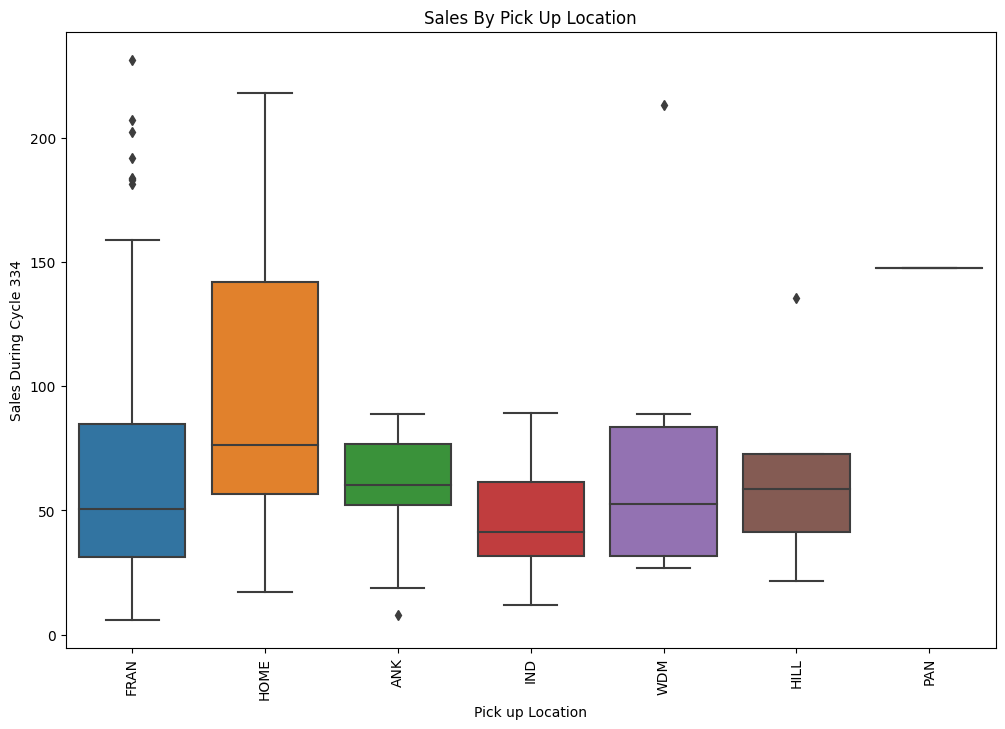

In [173]:
#Sales during most recent ordering period.
plt.subplots(figsize=(12, 8))
sns.boxplot(x='CDLocLast', y='SaleNom', data=df[(df['IDCyc']==334) & (df['SaleNom']>0)])
plt.xticks(rotation='vertical')
plt.xlabel('Pick Up Location')
plt.ylabel('Sales During Cycle 334')
plt.title('Sales By Pick Up Location')
plt.savefig('Sales_by_location.png',bbox_inches='tight')
plt.xlabel('Pick up Location');

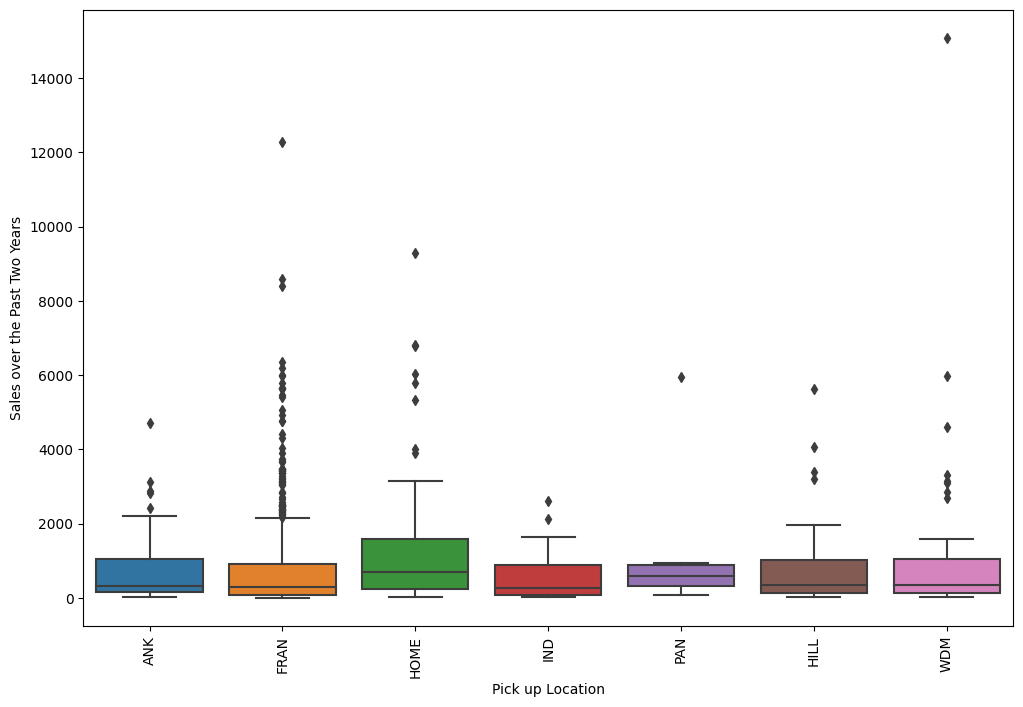

In [140]:
#Lifetime sales by customer and pick up location.
plt.subplots(figsize=(12, 8))
sns.boxplot(x='CDLocLast', y='Cumulative_Sum', data=df[df['IDCyc']==334])
plt.xticks(rotation='vertical')
plt.ylabel('Sales over the Past Two Years')
plt.xlabel('Pick up Location');

In [141]:
df.columns

Index(['IDCyc', 'WhenStartPickup', 'IDMemb', 'WhenReg', 'Addr1', 'Addr2',
       'City', 'St', 'Zip', 'CDLocLast', 'NumLogins', 'CkFounder', 'HowHear',
       'CDRegMemb', 'SaleNom', 'Baked Goods', 'Beverages',
       'Classes and Events', 'Condiments + Sauces', 'Dairy',
       'Dried Herbs + Spices', 'Eggs', 'Grains, Flours, Cereal + Pastas',
       'Handmade Home Goods + Gifts', 'Honey, Syrups, Jams + Jellies',
       'Iowa Food Co-op Shop', 'Local Produce', 'Meat - Beef',
       'Meat - Chicken + Capon', 'Meat - Pork', 'Meats - Other',
       'Non-Food Items', 'Nuts', 'Other Protein Sources', 'Personal Care',
       'Pet + Animal Care', 'Prepared Foods', 'Snacks', 'The Garden Center',
       'full_address', 'latitude', 'longitude', 'Pickup_lat', 'Pickup_long',
       'Distance_to_pickup', 'Years_member', 'quarter', 'month', 'holiday',
       'Cumulative_Sum', 'Ordered', 'Cumulative_Number_of_Orders',
       'order_per_cycle_when_ordering', 'Cycles_as_member', 'order_per_cycle'],
   

Text(0.5, 0, 'Years as a Member')

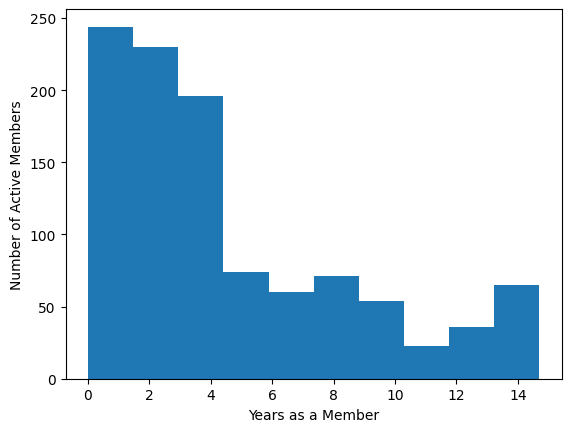

In [142]:
#Number of Customers and how long they have been members
plt.hist(data=df[df['IDCyc']==334], x = 'Years_member')
plt.ylabel('Number of Active Members')
plt.xlabel('Years as a Member')

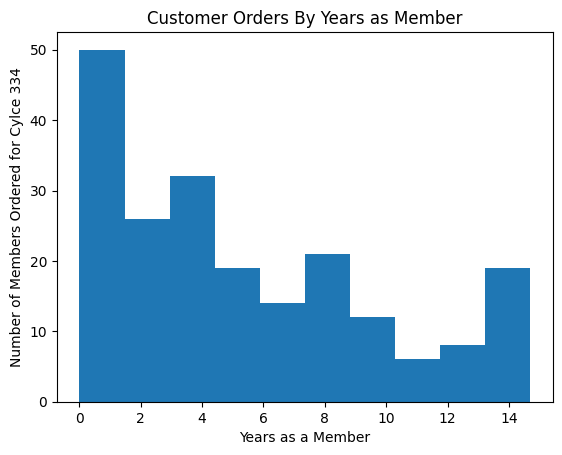

In [175]:
#Histogram of who is ordering recently--new members vs. old members.
plt.hist(data=df[(df['IDCyc']==334) & df['SaleNom']>0], x = 'Years_member')
plt.ylabel('Number of Members Ordered for Cylce 334')
plt.xlabel('Years as a Member')
plt.title('Customer Orders By Years as Member')
plt.savefig('Orders_by_years',bbox_inches='tight')

Text(0.5, 0, '# of Times Ordered')

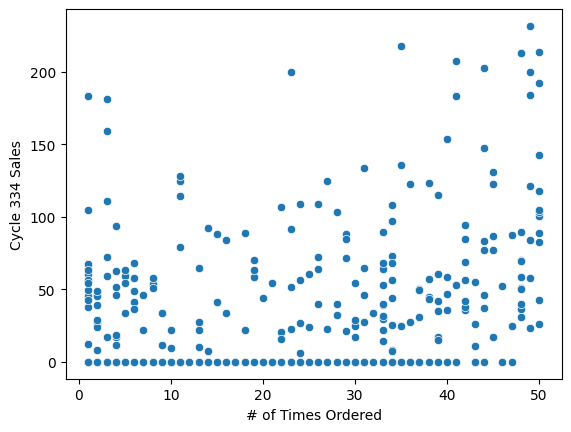

In [144]:
#Scatterplot showing amount of most recent order vs. how many times the customer has ordered in the past.
sns.scatterplot(data = df[df['IDCyc']==334], x = 'Cumulative_Number_of_Orders', y='SaleNom')
plt.ylabel('Cycle 334 Sales')
plt.xlabel('# of Times Ordered')

Text(0.5, 0, 'Distance to pickup (miles)')

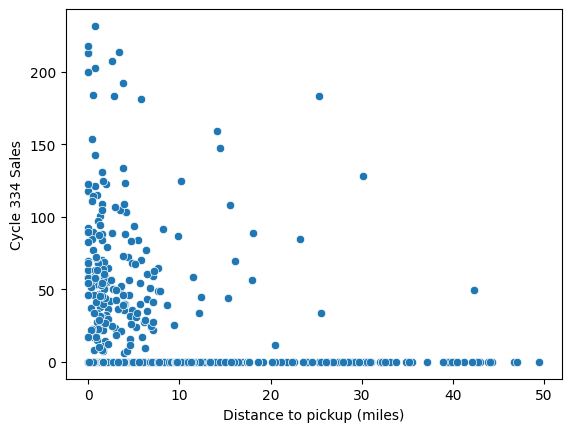

In [145]:
#Scatterplot of order vs. miles to pickup
sns.scatterplot(data = df[(df['Distance_to_pickup']<50) & (df['IDCyc']==334)], x = 'Distance_to_pickup', y='SaleNom')
plt.ylabel('Cycle 334 Sales')
plt.xlabel('Distance to pickup (miles)')

Text(0.5, 0, 'Distance to pickup (miles)')

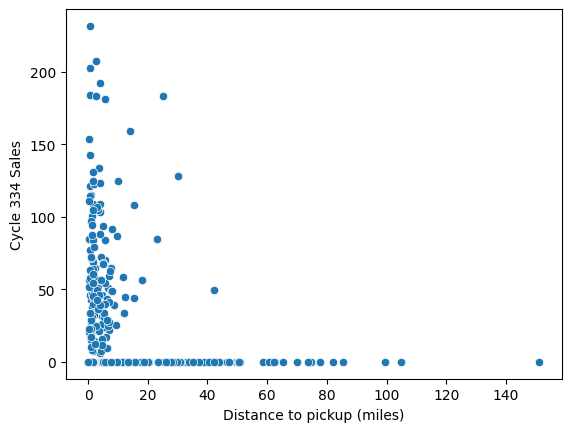

In [146]:
#Scatterplot of order vs. miles to pickup at Franklin location
sns.scatterplot(data = df[(df['CDLocLast']=='FRAN') & (df['IDCyc']==334)], x = 'Distance_to_pickup', y='SaleNom')
plt.ylabel('Cycle 334 Sales')
plt.xlabel('Distance to pickup (miles)')

Text(0.5, 0, 'Distance to pickup (miles)')

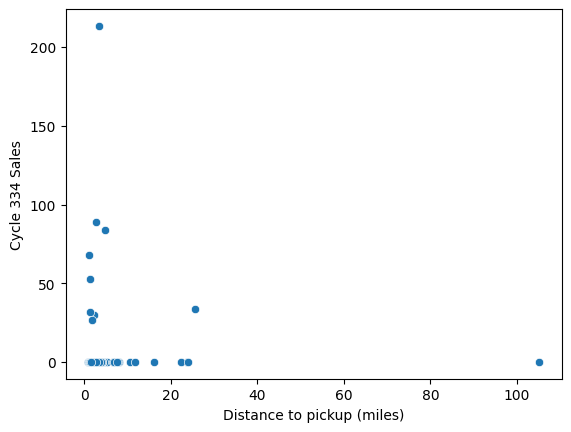

In [147]:
#Scatterplot of order vs. miles to pickup at West Des Moines location
sns.scatterplot(data = df[(df['CDLocLast']=='WDM') & (df['IDCyc']==334)], x = 'Distance_to_pickup', y='SaleNom')
plt.ylabel('Cycle 334 Sales')
plt.xlabel('Distance to pickup (miles)')

Text(0.5, 0, 'Distance to pickup (miles)')

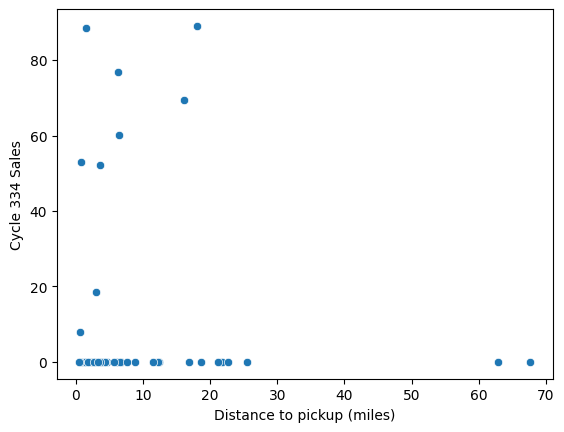

In [148]:
#Scatterplot of order vs. miles to pickup at Ankeny location
sns.scatterplot(data = df[(df['CDLocLast']=='ANK') & (df['IDCyc']==334)], x = 'Distance_to_pickup', y='SaleNom')
plt.ylabel('Cycle 334 Sales')
plt.xlabel('Distance to pickup (miles)')

Text(0.5, 0, 'Total Sales')

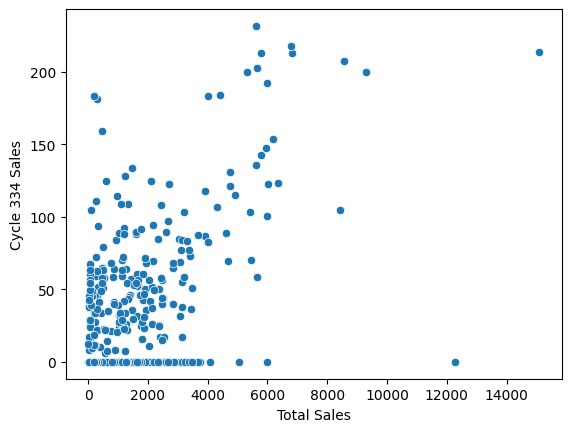

In [149]:
#Scatter plot of most recent ordering period vs. lifetime sales
sns.scatterplot(data = df[df['IDCyc']==334], x = 'Cumulative_Sum', y='SaleNom')
plt.ylabel('Cycle 334 Sales')
plt.xlabel('Total Sales')

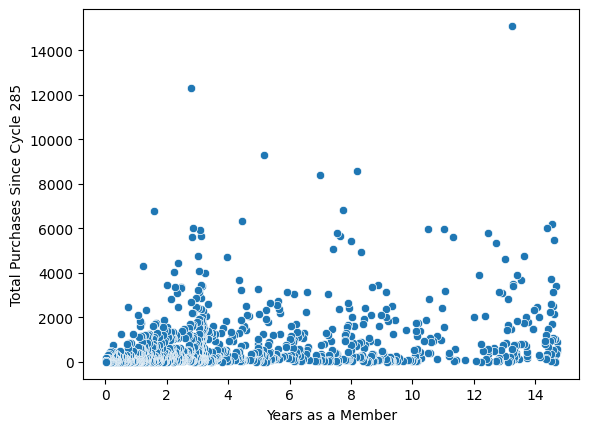

In [150]:
#Total Years as member vs. total purchases over last 2+ years.
sns.scatterplot(data = df[df['IDCyc']==334], x = 'Years_member', y='Cumulative_Sum');
plt.ylabel('Total Purchases Since Cycle 285');
plt.xlabel('Years as a Member');

In [151]:
df.columns

Index(['IDCyc', 'WhenStartPickup', 'IDMemb', 'WhenReg', 'Addr1', 'Addr2',
       'City', 'St', 'Zip', 'CDLocLast', 'NumLogins', 'CkFounder', 'HowHear',
       'CDRegMemb', 'SaleNom', 'Baked Goods', 'Beverages',
       'Classes and Events', 'Condiments + Sauces', 'Dairy',
       'Dried Herbs + Spices', 'Eggs', 'Grains, Flours, Cereal + Pastas',
       'Handmade Home Goods + Gifts', 'Honey, Syrups, Jams + Jellies',
       'Iowa Food Co-op Shop', 'Local Produce', 'Meat - Beef',
       'Meat - Chicken + Capon', 'Meat - Pork', 'Meats - Other',
       'Non-Food Items', 'Nuts', 'Other Protein Sources', 'Personal Care',
       'Pet + Animal Care', 'Prepared Foods', 'Snacks', 'The Garden Center',
       'full_address', 'latitude', 'longitude', 'Pickup_lat', 'Pickup_long',
       'Distance_to_pickup', 'Years_member', 'quarter', 'month', 'holiday',
       'Cumulative_Sum', 'Ordered', 'Cumulative_Number_of_Orders',
       'order_per_cycle_when_ordering', 'Cycles_as_member', 'order_per_cycle'],
   

<Axes: xlabel='IDMemb', ylabel='order_per_cycle'>

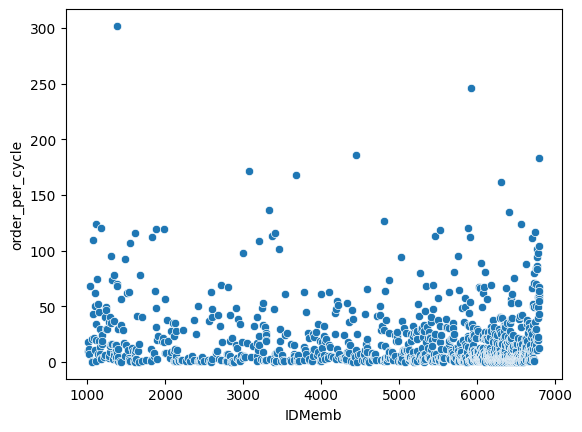

In [152]:
#order per cycle comparison
sns.scatterplot(data = df[df['IDCyc']==334], x='IDMemb', y = 'order_per_cycle')

<Axes: xlabel='IDMemb', ylabel='order_per_cycle_when_ordering'>

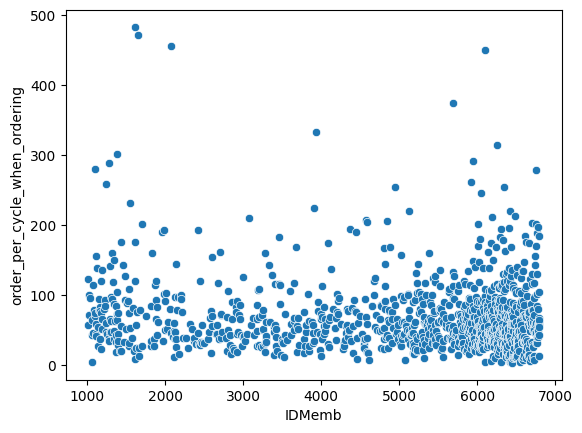

In [153]:
#How much customers spend when they order.
sns.scatterplot(data = df[df['IDCyc']==334], x='IDMemb', y = 'order_per_cycle_when_ordering')

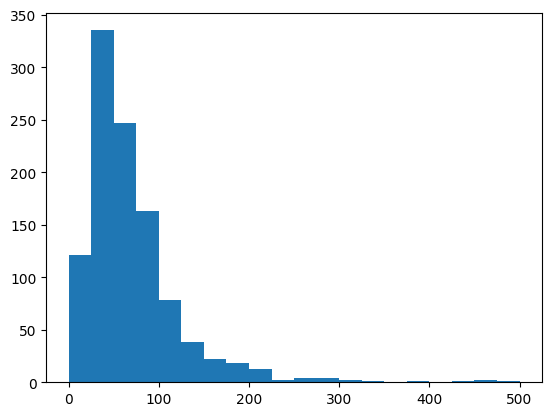

In [154]:
plt.hist(data=df[df['IDCyc']==334], x='order_per_cycle_when_ordering', range = [0,500],bins=20);

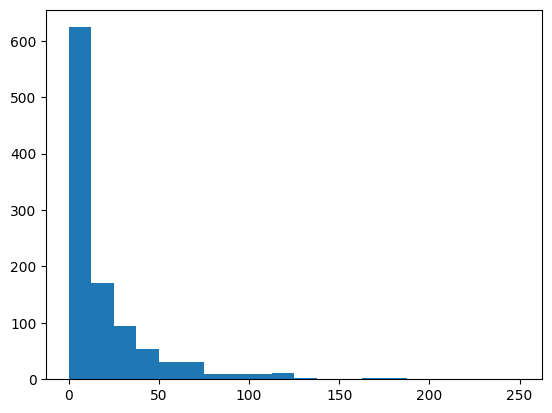

In [155]:
plt.hist(data=df[df['IDCyc']==334], x='order_per_cycle', range = [0,250],bins=20);

In [156]:
#checking correlations between each variable and the most recent ordering period.
Series_2=df[df['IDCyc']==334].corr()['SaleNom']
print(Series_2)

IDCyc                                   NaN
IDMemb                            -0.106518
NumLogins                          0.234236
CkFounder                          0.059814
SaleNom                            1.000000
Baked Goods                        0.467346
Beverages                          0.488076
Classes and Events                      NaN
Condiments + Sauces                0.285544
Dairy                              0.433956
Dried Herbs + Spices               0.160397
Eggs                               0.508880
Grains, Flours, Cereal + Pastas    0.287640
Handmade Home Goods + Gifts        0.131968
Honey, Syrups, Jams + Jellies      0.171002
Iowa Food Co-op Shop               0.258098
Local Produce                      0.648706
Meat - Beef                        0.425611
Meat - Chicken + Capon             0.378147
Meat - Pork                        0.396299
Meats - Other                      0.349155
Non-Food Items                          NaN
Nuts                            

/var/folders/7b/nyzqb3pd1zn309ndm96_lqcm0000gn/T/ipykernel_74391/1341443147.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Series_2=df[df['IDCyc']==334].corr()['SaleNom']


In [157]:
df2 = pd.DataFrame(Series_2)
df2.head(60)

,SaleNom
IDCyc,NaN
IDMemb,-0.106518
NumLogins,0.234236
CkFounder,0.059814
SaleNom,1.000000
Baked Goods,0.467346
Beverages,0.488076
Classes and Events,NaN
Condiments + Sauces,0.285544
Dairy,0.433956


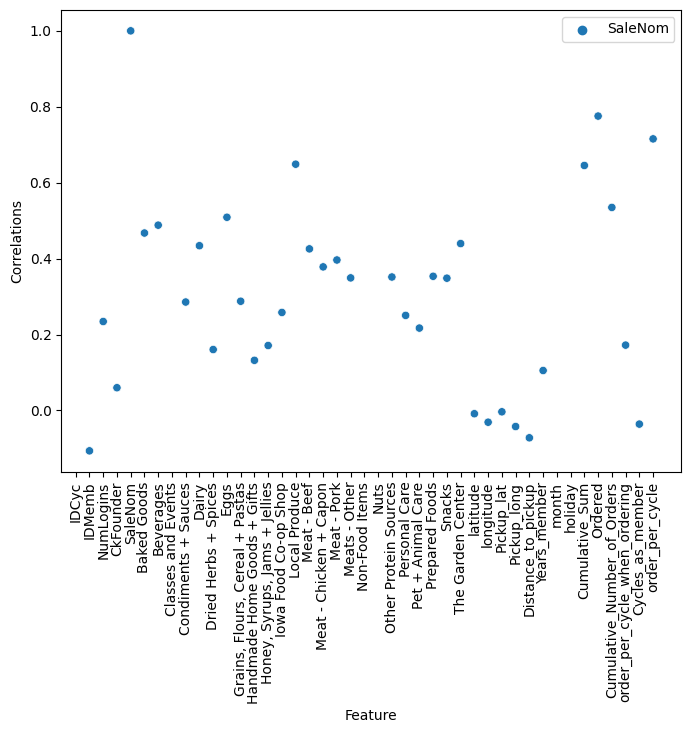

In [158]:
#graphing the correlations
fig, ax = plt.subplots(figsize=(8, 6));
sns.scatterplot(data=df2);
plt.xlabel('Feature');
plt.ylabel('Correlations');
plt.xticks(rotation=90);

In [159]:
#NumLogins is just the total logins a customer has made--it doesn't accumulate, so we can't use it in our modelling.
df.drop(['NumLogins'], axis=1, inplace=True)

In [ ]:
df.reset_index(drop=True)

In [ ]:
df.head(-10)

In [162]:
df.columns

Index(['IDCyc', 'WhenStartPickup', 'IDMemb', 'WhenReg', 'Addr1', 'Addr2',
       'City', 'St', 'Zip', 'CDLocLast', 'CkFounder', 'HowHear', 'CDRegMemb',
       'SaleNom', 'Baked Goods', 'Beverages', 'Classes and Events',
       'Condiments + Sauces', 'Dairy', 'Dried Herbs + Spices', 'Eggs',
       'Grains, Flours, Cereal + Pastas', 'Handmade Home Goods + Gifts',
       'Honey, Syrups, Jams + Jellies', 'Iowa Food Co-op Shop',
       'Local Produce', 'Meat - Beef', 'Meat - Chicken + Capon', 'Meat - Pork',
       'Meats - Other', 'Non-Food Items', 'Nuts', 'Other Protein Sources',
       'Personal Care', 'Pet + Animal Care', 'Prepared Foods', 'Snacks',
       'The Garden Center', 'full_address', 'latitude', 'longitude',
       'Pickup_lat', 'Pickup_long', 'Distance_to_pickup', 'Years_member',
       'quarter', 'month', 'holiday', 'Cumulative_Sum', 'Ordered',
       'Cumulative_Number_of_Orders', 'order_per_cycle_when_ordering',
       'Cycles_as_member', 'order_per_cycle'],
      dtype='obj

In [163]:
df.isna().sum()

IDCyc                                  0
WhenStartPickup                        0
IDMemb                                 0
WhenReg                                0
Addr1                                  0
Addr2                              42242
City                                   0
St                                     0
Zip                                    0
CDLocLast                              0
CkFounder                              0
HowHear                                0
CDRegMemb                              0
SaleNom                                0
Baked Goods                            0
Beverages                              0
Classes and Events                     0
Condiments + Sauces                    0
Dairy                                  0
Dried Herbs + Spices                   0
Eggs                                   0
Grains, Flours, Cereal + Pastas        0
Handmade Home Goods + Gifts            0
Honey, Syrups, Jams + Jellies          0
Iowa Food Co-op 

In [164]:
df[(df['Cumulative_Sum']==0) & (df['IDCyc']==334)]

,IDCyc,WhenStartPickup,IDMemb,WhenReg,Addr1,Addr2,City,St,Zip,CDLocLast,...,Years_member,quarter,month,holiday,Cumulative_Sum,Ordered,Cumulative_Number_of_Orders,order_per_cycle_when_ordering,Cycles_as_member,order_per_cycle


In [165]:
df.columns

Index(['IDCyc', 'WhenStartPickup', 'IDMemb', 'WhenReg', 'Addr1', 'Addr2',
       'City', 'St', 'Zip', 'CDLocLast', 'CkFounder', 'HowHear', 'CDRegMemb',
       'SaleNom', 'Baked Goods', 'Beverages', 'Classes and Events',
       'Condiments + Sauces', 'Dairy', 'Dried Herbs + Spices', 'Eggs',
       'Grains, Flours, Cereal + Pastas', 'Handmade Home Goods + Gifts',
       'Honey, Syrups, Jams + Jellies', 'Iowa Food Co-op Shop',
       'Local Produce', 'Meat - Beef', 'Meat - Chicken + Capon', 'Meat - Pork',
       'Meats - Other', 'Non-Food Items', 'Nuts', 'Other Protein Sources',
       'Personal Care', 'Pet + Animal Care', 'Prepared Foods', 'Snacks',
       'The Garden Center', 'full_address', 'latitude', 'longitude',
       'Pickup_lat', 'Pickup_long', 'Distance_to_pickup', 'Years_member',
       'quarter', 'month', 'holiday', 'Cumulative_Sum', 'Ordered',
       'Cumulative_Number_of_Orders', 'order_per_cycle_when_ordering',
       'Cycles_as_member', 'order_per_cycle'],
      dtype='obj

In [166]:
df.drop(['Addr1', 'Addr2','City', 'St', 'Zip','CDRegMemb','full_address'],axis=1,inplace=True)

In [167]:
df.head()

,IDCyc,WhenStartPickup,IDMemb,WhenReg,CDLocLast,CkFounder,HowHear,SaleNom,Baked Goods,Beverages,...,Years_member,quarter,month,holiday,Cumulative_Sum,Ordered,Cumulative_Number_of_Orders,order_per_cycle_when_ordering,Cycles_as_member,order_per_cycle
99,285,2021-07-01 16:30:00,1016,2008-09-10,ANK,1,Other,0.00,0.0,0.0,...,12.815582,2021Q3,7,1,0.00,0,0,0.00,1,0.00
149,285,2021-07-01 16:30:00,1017,2008-09-10,FRAN,1,Other,0.00,0.0,0.0,...,12.815582,2021Q3,7,1,0.00,0,0,0.00,1,0.00
299,285,2021-07-01 16:30:00,1021,2008-09-11,ANK,0,Other,0.00,0.0,0.0,...,12.812842,2021Q3,7,1,0.00,0,0,0.00,1,0.00
399,285,2021-07-01 16:30:00,1023,2008-09-12,FRAN,0,Other,67.25,0.0,0.0,...,12.810103,2021Q3,7,1,67.25,1,1,67.25,1,67.25
799,285,2021-07-01 16:30:00,1040,2008-09-17,FRAN,1,Other,0.00,0.0,0.0,...,12.796404,2021Q3,7,1,0.00,0,0,0.00,1,0.00


In [168]:
filepath = '/Users/emilydanielbowser/Documents/Iowa Food Coop/Data/Intermediate Data/EDA'
df.to_csv(filepath)